# Overview


This demo shows how to load semantic segmentation maps for `Biased-Cars Dataset`.

In [1]:
%matplotlib inline
from IPython.display import Image

In [2]:
CODE_ROOT = '..'

In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
import argparse
import pickle
import sys
sys.path.append('%s/res/'%CODE_ROOT)
from models.models import get_model
from loader.loader import get_loader
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("Set1", 8, .75)
sns.despine()

/net/storage001.ib.cluster/om2/user/smadan/generalization_to_OOD_category_viewpoint_cominations/demos
../res/loader/loader.py
../res/loader


<Figure size 432x288 with 0 Axes>

# Sample images from the dataset

In [4]:
image_url = "../docs/images/biased_cars_samples.gif"
Image(url=image_url, width=500)

### Make sure biased-cars data is downloaded and formatted

If data isn't downloaded, please run the bash script under `utils` following:

```
cd utils
bash download_biased_cars.sh
```

In [27]:
DATASET_NAMES = ['rotation_model_15_compositions_seen']

NUM_EPOCHS = 10
BATCH_SIZE = 10
ARCH = 'LATE_BRANCHING_COMBINED'

image_transform=transforms.Compose([
        transforms.ToTensor(),
    ])


GPU = 1

In [28]:
loader_new = get_loader('multi_attribute_loader_file_list_semantic_segmentation')
file_list_root = '%s/dataset_lists/biased_cars_lists/'%CODE_ROOT
att_path = "%s/data/biased_cars/att_dict_simplified.p"%CODE_ROOT

In [29]:
shuffles = {'train':True,'val':True,'test':False}

In [30]:
data_dir = '%s/data/'%CODE_ROOT

In [31]:
all_dsets = {}
all_dset_loaders = {}
all_dset_sizes = {}

for DATASET_NAME in DATASET_NAMES:
    file_lists = {}
    dsets = {}
    dset_loaders = {}
    dset_sizes = {}
    for phase in ['train','val','test']:
        file_lists[phase] = "%s/%s_list_%s.txt"%(file_list_root,phase,DATASET_NAME)
        dsets[phase] = loader_new(file_lists[phase],att_path, image_transform, data_dir)
        dset_loaders[phase] = torch.utils.data.DataLoader(dsets[phase], batch_size=BATCH_SIZE, shuffle = shuffles[phase], num_workers=2,drop_last=True)
        dset_sizes[phase] = len(dsets[phase])
    all_dsets[DATASET_NAME] = dsets
    all_dset_loaders[DATASET_NAME] = dset_loaders
    all_dset_sizes[DATASET_NAME] = dset_sizes

In [32]:
labelval_to_category={60:'building',
                      59:'curb',
                      11:'humans',
                      58:'road',
                      57:'sidewalk',
                      0:'sky',
                      129:'trees',
                      31:'unknown',
                      56:'vegetation',
                      1:'unknown',
                      255:'car',
}

category_to_class_number = {
    'sky': 0,
    'building': 1,
    'humans': 2,
    'road': 3,
    'curb': 4,
    'sidewalk': 5,
    'trees': 6,
    'vegetation': 7,
    'unknown': 8,
    'car':9
}

def format_label(imarray):
    imarray = imarray[:,:,0]
    for val in labelval_to_category.keys():
        imarray[imarray==val] = category_to_class_number[labelval_to_category[val]]
        
    imarray[imarray>150] = 9
    
    label_size = imarray.shape[0]
    num_classes = 10
    formatted_label = np.zeros((num_classes, label_size, label_size))
    for i in range(num_classes):
        formatted_label[i] = imarray==i
    return formatted_label

In [38]:
for data in dset_loaders['test']:
    inputs, semantic_maps,_ = data
    break

In [39]:
inputs.shape

torch.Size([10, 3, 256, 256])

In [40]:
semantic_maps.shape

torch.Size([10, 10, 256, 256])

In [97]:
img_num = 4

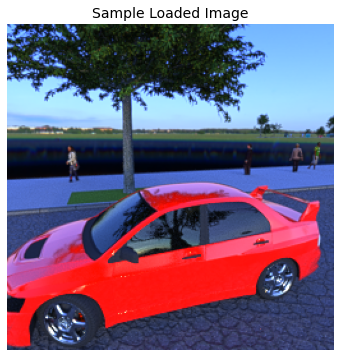

In [98]:
plt.figure(figsize=(6,6))
plt.imshow(inputs[img_num].permute(1,2,0))
plt.axis('off')
plt.title('Sample Loaded Image',size=14)
plt.show()

In [99]:
id_to_category = {
    0:'sky',
    1:'building',
    2:'humans',
    3:'road',
    4:'curb',
    5:'sidewalk',
    6:'trees',
    7:'vegetation',
    8:'unknown',
    9:'cars'
}

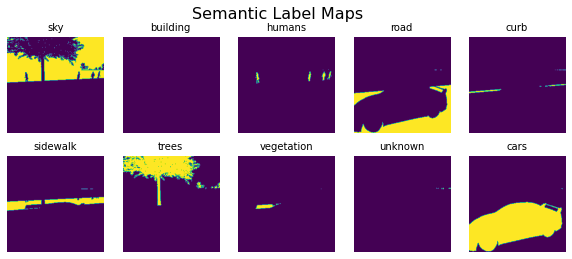

In [100]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
for row_num in range(2):
    for col_num in range(5):
        inst_num = col_num + 5*(row_num)
        ax[row_num][col_num].imshow(semantic_maps[img_num][inst_num])
        ax[row_num][col_num].axis('off')
        ax[row_num][col_num].set_title(id_to_category[inst_num],size=10)

plt.suptitle('Semantic Label Maps', size=16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()